In [18]:
#ИМПОРТ И ФУНКЦИИ С КЛАССАМИ
import os
import glob
import h5py
import torch
import random
import pickle
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import Subset
from IPython.display import Audio, display
from sklearn.metrics import f1_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
import tqdm

# выбираем устройство
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  

#класс датасета
class AudioDataset(Dataset):
    def __init__(self, h5_path):
        self.h5_path = h5_path
        self.file = h5py.File(h5_path, 'r')
        
        self.spectrograms = self.file['spectrograms']
        self.labels = self.file['labels']
        self.class_names = [name.decode('utf-8') for name in self.file.attrs['class_names']]
        self.num_classes = self.file.attrs['num_classes']
        
        print(f"Loaded {len(self.spectrograms)} samples from HDF5")
    
    def __len__(self):
        return len(self.spectrograms)
    
    def __getitem__(self, idx):
        # Загружаем непосредственно из HDF5
        spectrogram = torch.tensor(self.spectrograms[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.float32)
        return spectrogram, label
    
    def __del__(self):
        if hasattr(self, 'file'):
            self.file.close()
    
    def get_class_names(self):
        return self.class_names 
#функция потерь (для теста)
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        
    def forward(self, inputs, targets):
        bce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-bce_loss)
        focal_loss = self.alpha * (1-pt)**self.gamma * bce_loss
        return focal_loss.mean()
#CNN + classifier    
class AudioCNN(nn.Module):
    def __init__(self, num_classes, input_channels=1):
        
        super(AudioCNN, self).__init__()
        
        # CNN
        self.conv_layers = nn.Sequential(
            
            # Блок 1 - Низкоуровневые признаки
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.1),
            
            # Блок 2 - Среднеуровневые признаки  
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(0.2),
            
            # Блок 3 - Высокоуровневые признаки
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.AdaptiveAvgPool2d((4, 8)),  # Фиксированный выход 4×4
        )

        # FC
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 4 * 8, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.4),

            nn.Linear(512, num_classes)
        )

        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Conv2d):
            nn.init.kaiming_uniform_(m.weight, mode='fan_out', nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0.1)
                
        elif isinstance(m, (nn.BatchNorm2d, nn.BatchNorm1d)):
            nn.init.constant_(m.weight, 1.0)
            nn.init.constant_(m.bias, 0.0)
            
        elif isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            nn.init.constant_(m.bias, 0.1)

    #     self._initialize_weights()

    # def _initialize_weights(self):
    #     for m in self.modules():
    #         if isinstance(m, nn.Conv2d):
    #             nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
    #             if m.bias is not None:
    #                 nn.init.constant_(m.bias, 0)
    #         elif isinstance(m, nn.Linear):
    #             nn.init.xavier_uniform_(m.weight)
    #             if m.bias is not None:
    #                 nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.classifier(x)
        return x
    
#полносвязная
class SimpleFCModel(nn.Module):
    def __init__(self, num_classes: int, input_height: int, input_width: int, hidden_size: int = 256):
        super(SimpleFCModel, self).__init__()
        
        self.input_height = input_height
        self.input_width = input_width
        self.num_classes = num_classes
        
        # Вычисляем размер после вытягивания в вектор
        self.flatten_size = input_height * input_width
        
        self.layers = nn.Sequential(
            # Вытягиваем в плоский вектор
            nn.Flatten(),
            
            # Первый скрытый слой
            nn.Linear(self.flatten_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(0.5),  # для регуляризации
            
            # Второй скрытый слой (можно добавить больше)
            nn.Linear(hidden_size, hidden_size // 2),
            nn.ReLU(), 
            nn.Dropout(0.4),
            
            # Выходной слой
            nn.Linear(hidden_size // 2, num_classes)
        )
    
    def forward(self, x):
        x = self.layers(x)
        return x
#метрики
def calculate_all_metrics(y_true, y_pred, loss, threshold):
    
    metrics = {}
    # Loss
    metrics['loss'] = loss
    # F1 Macro - баланс между классами (ОСНОВНАЯ)
    metrics['f1_macro'] = f1_score(y_true, y_pred, average='macro', zero_division=0)
    # Precision Macro - контроль false positive
    metrics['precision_macro'] = precision_score(y_true, y_pred, average='macro', zero_division=0)
    # Recall Macro - контроль false negative
    metrics['recall_macro'] = recall_score(y_true, y_pred, average='macro', zero_division=0)
    # Threshold - порог опредления label'а
    metrics['threshold'] = threshold

    # F1 для каждого класса
    f1_per_class = f1_score(y_true, y_pred, average=None, zero_division=0)
    metrics['f1_per_class'] = f1_per_class
    
    return metrics

def train_epoch(model, loader, optimizer, criterion, epoch, num_epochs, threshold):
    model.train()
    all_targets = []
    all_predictions = []
    all_loss = 0.0
    output = []
    
    # Создаем прогресс-бар
    pbar = tqdm.tqdm(loader, desc=f'Epoch {epoch}/{num_epochs}', 
                bar_format='{l_bar}{bar:20}{r_bar}{bar:-20b}')
    
    for data, targets in pbar:
        data = data.to(device)
        targets = targets.to(device)   
        optimizer.zero_grad()                          
        outputs = model(data)                          
        loss = criterion(outputs, targets)             
        all_loss += loss.item()

        loss.backward()                                
        optimizer.step()                                 
        
        # Сохраняем предсказания и цели для метрик
        with torch.no_grad():            
            probs = torch.sigmoid(outputs)           
            predictions = (probs > threshold).float()            
            all_targets.append(targets.cpu())           
            all_predictions.append(predictions.cpu())
            
        # Обновляем прогресс-бар
        current_loss = all_loss / (pbar.n + 1)
        pbar.set_postfix({'Loss': f'{current_loss:.4f}'})

    all_targets = torch.cat(all_targets).numpy()
    all_predictions = torch.cat(all_predictions).numpy()
    all_loss /= len(loader)

    return calculate_all_metrics(all_targets, all_predictions, all_loss, threshold)

def evaluate_epoch(model, loader, criterion, threshold, auto_threshold):
    model.eval()
    all_targets = []
    all_predictions = []
    all_probs = []
    all_loss = 0.0
    
    with torch.no_grad():
        for data, targets in loader:  
            data = data.to(device)
            targets = targets.to(device) 
            outputs = model(data)                       
            loss = criterion(outputs, targets)
            all_loss += loss.item()
            
            probs = torch.sigmoid(outputs)   
            predictions = (probs > threshold).float()   
            
            all_targets.append(targets.cpu())          
            all_predictions.append(predictions.cpu())
            all_probs.append(probs.cpu())
    
    all_targets = torch.cat(all_targets).numpy()
    all_predictions = torch.cat(all_predictions).numpy()
    all_probs = torch.cat(all_probs)
    all_loss /= len(loader)

    best_threshold = threshold
    best_f1 = 0.0
    
    # расчёт лучшего порога
    if auto_threshold:
        for threshold in torch.arange(0.05, 0.9, 0.05):
            predictions = (all_probs > threshold).float()
            f1 = f1_score(all_targets, predictions, average='macro')
            if f1 > best_f1:
                best_f1 = f1
                best_threshold = threshold.item()

    return calculate_all_metrics(all_targets, all_predictions, all_loss, best_threshold)

def train_model(model, train_loader, val_loader, optimizer, criterion, patience=10,
                num_epochs=50, threshold=0.5, save_dir='../data/models', 
                start_epoch=1, history=None, best_f1=0.0, auto_threshold=False):
    
    os.makedirs(save_dir, exist_ok=True)

    # Инициализация истории, если не передана
    if history is None:
        history = {
            'train_loss': [], 'val_loss': [],
            'train_f1': [], 'val_f1': [],
            'train_precision': [], 'val_precision': [],
            'train_recall': [], 'val_recall': [],
            'train_threshold': [], 'val_threshold': [],
            'epochs_completed': 0,
            'total_epochs': num_epochs,
            'best_f1': 0.0,
            'f1_per_class':[]
        }
    
    patience_counter = 0

    for epoch in range(start_epoch, start_epoch + num_epochs):
        # Обучение и валидация
        train_metrics = train_epoch(model, train_loader, optimizer, criterion, epoch, start_epoch + num_epochs - 1, threshold)
        val_metrics = evaluate_epoch(model, val_loader, criterion, threshold, auto_threshold)
        
        # Сохраняем историю
        history['train_loss'].append(train_metrics['loss'])
        history['val_loss'].append(val_metrics['loss'])
        history['train_f1'].append(train_metrics['f1_macro'])
        history['val_f1'].append(val_metrics['f1_macro'])
        history['train_precision'].append(train_metrics['precision_macro'])
        history['val_precision'].append(val_metrics['precision_macro'])
        history['train_recall'].append(train_metrics['recall_macro'])
        history['val_recall'].append(val_metrics['recall_macro'])
        history['epochs_completed'] = epoch
        history['best_f1'] = max(history.get('best_f1', 0.0), val_metrics['f1_macro'])
        history['f1_per_class'] = val_metrics['f1_per_class']

        # Выводим метрики
        print("─" * 50)
        print(f"Epoch {epoch}/{start_epoch + num_epochs - 1}")
        print(f"Train >>> Loss: {train_metrics['loss']:.4f} | F1: {train_metrics['f1_macro']:.4f} | "
              f"Precision: {train_metrics['precision_macro']:.4f} | Recall: {train_metrics['recall_macro']:.4f} | "
              f"Threshold: {threshold:.2f}")

        print(f"Val   >>> Loss: {val_metrics['loss']:.4f} | F1: {val_metrics['f1_macro']:.4f} | "
              f"Precision: {val_metrics['precision_macro']:.4f} | Recall: {val_metrics['recall_macro']:.4f} | "
              f"Threshold: {threshold:.2f}")

        # обновляем threshold
        threshold = val_metrics['threshold'] 

        # Early stopping и сохранение лучшей модели
        if val_metrics['f1_macro'] > best_f1:
            best_f1 = val_metrics['f1_macro']
            # Сохраняем полное состояние для продолжения обучения
            history_copy = history.copy()
            history_copy.pop('f1_per_class')
            checkpoint = {
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'history': history_copy,
                'epoch': epoch,
                'best_f1': best_f1,
                'patience_counter': patience_counter,
                'threshold': threshold
            }
            torch.save(checkpoint, f'{save_dir}/best_model.pth')
            patience_counter = 0
            print(f"Новая лучшая модель сохранена! F1: {best_f1:.4f}")
        else:
            patience_counter += 1
            print(f"Нет улучшений: ({patience_counter}/{patience})")
            
        if patience_counter >= patience:
            print(f"Ранняя остановка на эпохе {epoch}.")
            break

        # Сохраняем последнюю модель каждые N эпох
        if epoch % 5 == 0:
            checkpoint = {
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'history': history,
                'epoch': epoch,
                'best_f1': best_f1,
                'patience_counter': patience_counter,
                'threshold': threshold
            }
            torch.save(checkpoint, f'{save_dir}/checkpoint_epoch_{epoch}.pth')

        print("\n")

    # Финальное сохранение
    final_checkpoint = {
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'history': history,
        'epoch': epoch,
        'best_f1': best_f1,
        'patience_counter': patience_counter,
        'threshold': threshold
    }
    torch.save(final_checkpoint, f'{save_dir}/last_model.pth')

    return history, best_f1

def load_checkpoint(model, optimizer, checkpoint_path, device):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    
    history = checkpoint['history']
    start_epoch = checkpoint['epoch'] + 1
    best_f1 = checkpoint['best_f1']
    threshold = checkpoint.get('threshold', 0.5)
    
    print(f"Загружен чекпоинт эпохи {checkpoint['epoch']}")
    print(f"Лучший F1: {best_f1:.4f}")
    print(f"Всего эпох в истории: {len(history['train_loss'])} \n")
    
    return model, optimizer, history, start_epoch, best_f1, threshold

def plot_training_history(history, save_path=None):
    
    fig, axes = plt.subplots(3, 2, figsize=(15, 14))
    fig.suptitle('История тренировки', fontsize=16, fontweight='bold')
    
    epochs = range(1, len(history['train_loss']) + 1)
    
    gs = plt.GridSpec(3, 2, figure=fig)

    # 1. Loss
    ax1 = fig.add_subplot(gs[0,0])
    ax1.plot(epochs, history['train_loss'], 'b-', label='Train Loss', linewidth=2)
    ax1.plot(epochs, history['val_loss'], 'r-', label='Val Loss', linewidth=2)
    ax1.set_title('Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(0, 1.0)
    
    # 2. F1 Score
    ax2 = fig.add_subplot(gs[0,1])
    ax2.plot(epochs, history['train_f1'], 'b-', label='Train F1', linewidth=2)
    ax2.plot(epochs, history['val_f1'], 'r-', label='Val F1', linewidth=2)
    ax2.set_title('F1 Macro Score')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('F1 Score')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(0, 1.0)
    
    # 3. Precision
    ax3 = fig.add_subplot(gs[1,0])
    ax3.plot(epochs, history['train_precision'], 'b-', label='Train Precision', linewidth=2)
    ax3.plot(epochs, history['val_precision'], 'r-', label='Val Precision', linewidth=2)
    ax3.set_title('Precision Macro')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Precision')
    ax3.legend()
    ax3.grid(True, alpha=0.3)
    ax3.set_ylim(0, 1.0)
    
    # 4. Recall
    ax4 = fig.add_subplot(gs[1,1])
    ax4.plot(epochs, history['train_recall'], 'b-', label='Train Recall', linewidth=2)
    ax4.plot(epochs, history['val_recall'], 'r-', label='Val Recall', linewidth=2)
    ax4.set_title('Recall Macro')
    ax4.set_xlabel('Epoch')
    ax4.set_ylabel('Recall')
    ax4.legend()
    ax4.grid(True, alpha=0.3)
    ax4.set_ylim(0, 1.0)
    
    # 5. Гистограмма F1 по классам (нижняя строка на всю ширину)
    ax5 = fig.add_subplot(gs[2, :])
    
    if history['f1_per_class'] is not None:
        f1_scores = history['f1_per_class']
        n_classes = len(f1_scores)
        x = np.arange(n_classes)
        
        # Минималистичная гистограмма
        bars = ax5.bar(x, f1_scores, alpha=0.7, color='lightblue', edgecolor='navy', linewidth=0.5)
        
        # Настройки гистограммы
        ax5.set_title('F1-score по классам (последняя эпоха)', fontsize=12, pad=10)
        ax5.set_xlabel('Классы')
        ax5.set_ylabel('F1-score')
        ax5.set_ylim(0, 1.0)
        ax5.grid(True, alpha=0.3)
        
        # Подписи классов
        ax5.set_xticks(x)
        ax5.set_xticklabels([f'{i}' for i in range(n_classes)], rotation=45 if n_classes > 30 else 0, fontsize=8)
        
        # Линия среднего значения
        mean_f1 = np.mean(f1_scores)
        ax5.axhline(y=mean_f1, color='red', linestyle='--', alpha=0.8, 
                   label=f'Средний F1: {mean_f1:.3f}')
        ax5.legend()
        
        # Добавляем значения на столбцы для лучших классов (топ-5)
        if len(f1_scores) > 0:
            # Находим индексы топ-5 классов по F1
            top_indices = np.argsort(f1_scores)[-5:][::-1]
            for idx in top_indices:
                if f1_scores[idx] > 0:
                    ax5.text(idx, f1_scores[idx] + 0.02, f'{f1_scores[idx]:.2f}', 
                            ha='center', va='bottom', fontsize=7, fontweight='bold')
    else:
        ax5.text(0.5, 0.5, 'F1 по классам недоступен', 
                ha='center', va='center', transform=ax5.transAxes, fontsize=12)
        ax5.set_title('F1-score по классам')
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Graphs saved to: {save_path}")
    
    plt.show()

def calculate_pos_weight(dataset, max_weight=3.0, smoothing=1.0, beta=0.999):
    all_targets = []
    for i in range(len(dataset)):
        _, targets = dataset[i]
        all_targets.append(targets)

    all_targets = torch.stack(all_targets)
    
    positive_counts = all_targets.sum(dim=0) + smoothing
    negative_counts = (all_targets.size(0) - all_targets.sum(dim=0)) + smoothing

    # print(f"Позитивные: {positive_counts}")

    pos_weight = negative_counts / positive_counts

    pos_weight = torch.log(pos_weight + smoothing)
    pos_weight = max_weight * (pos_weight / pos_weight.mean())

    print(f"Коррекция весов: {pos_weight} \n")

    return pos_weight.to(device)



In [19]:
# ЗАГРУЗКА ДАТАСЕТА
# ----------------------------------------------------------
tags_dict = {}
# открываем подготовленный словрь
with open("../data/track_tags.pkl", 'rb') as file:
    tags_dict = pickle.load(file)

# загружаем датасет
dataset = AudioDataset("../data/preprocessed_dataset.h5")



# разбиваем датасет на train и test
dataset_size = len(dataset)
indices = list(range(dataset_size))

train_idx, test_idx = train_test_split(
    indices, 
    test_size = 0.1,
    train_size = 0.4,       
    random_state = 42        # для воспроизводимости
)

train_dataset = Subset(dataset, train_idx)
test_dataset = Subset(dataset, test_idx)

train_loader = DataLoader(
    train_dataset,
    batch_size=64,
    shuffle=True,  
    num_workers=8,   
    pin_memory=True,
    persistent_workers=True,
    prefetch_factor=2
)

test_loader = DataLoader(
    test_dataset,
    batch_size=64,
    shuffle=False,  
    num_workers=4,   
    pin_memory=True,
    persistent_workers=False,
    prefetch_factor=2
)

for data, targets in train_loader:
    print(f"DATA - shape: {data.shape}")
    print(f"       min: {data.min().item():.4f}, max: {data.max().item():.4f}")
    print(f"       mean: {data.mean().item():.4f}, std: {data.std().item():.4f}")
    print(f"target exemple: {targets[0]}")
    break

Loaded 18486 samples from HDF5
DATA - shape: torch.Size([64, 1, 128, 512])
       min: -13.8155, max: 12.0424
       mean: 0.5422, std: 4.4477
target exemple: tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1.])


Используется устройство: cuda
Количество параметров модели: 1103899

Коррекция весов: tensor([3.0746, 2.9974, 2.6699, 2.9762, 2.9156, 3.2336, 2.9814, 2.9832, 2.7321,
        3.0342, 3.4631, 2.7504, 2.2029, 2.7167, 2.7464, 3.0417, 3.2756, 2.3915,
        2.1579, 2.1052, 2.3657, 4.0613, 2.0234, 2.9419, 3.6335, 3.4317, 3.6699,
        1.9442, 3.8446, 3.7479, 3.5837, 3.8344, 2.4568, 2.4279, 2.5914, 3.0101,
        3.8549, 2.1955, 2.7167, 3.0629, 3.4379, 3.4165, 2.8487, 3.5058, 2.1093,
        3.5949, 2.7269, 2.5838, 4.0414, 3.0174, 2.9675, 2.9419, 2.9043, 3.3279,
        2.9011, 3.4045, 3.7710, 3.0047, 2.6464]) 

Загружен чекпоинт эпохи 3
Лучший F1: 0.0826
Всего эпох в истории: 3 



Epoch 4/103: 100%|████████████████████| 116/116 [00:07<00:00, 15.20it/s, Loss=0.2747]


──────────────────────────────────────────────────
Epoch 4/103
Train >>> Loss: 0.2747 | F1: 0.0847 | Precision: 0.0468 | Recall: 0.4865 | Threshold: 0.10
Val   >>> Loss: 0.2674 | F1: 0.0889 | Precision: 0.0542 | Recall: 0.3911 | Threshold: 0.10
Новая лучшая модель сохранена! F1: 0.0889




Epoch 5/103: 100%|████████████████████| 116/116 [00:07<00:00, 15.24it/s, Loss=0.2696]


──────────────────────────────────────────────────
Epoch 5/103
Train >>> Loss: 0.2696 | F1: 0.0914 | Precision: 0.0507 | Recall: 0.4808 | Threshold: 0.10
Val   >>> Loss: 0.2685 | F1: 0.0943 | Precision: 0.0612 | Recall: 0.3596 | Threshold: 0.10
Новая лучшая модель сохранена! F1: 0.0943




Epoch 6/103: 100%|████████████████████| 116/116 [00:16<00:00,  7.21it/s, Loss=0.2649]


──────────────────────────────────────────────────
Epoch 6/103
Train >>> Loss: 0.2649 | F1: 0.0976 | Precision: 0.0545 | Recall: 0.4855 | Threshold: 0.10
Val   >>> Loss: 0.2705 | F1: 0.0952 | Precision: 0.0677 | Recall: 0.3387 | Threshold: 0.10
Новая лучшая модель сохранена! F1: 0.0952




Epoch 7/103: 100%|████████████████████| 116/116 [00:18<00:00,  6.20it/s, Loss=0.2625]


──────────────────────────────────────────────────
Epoch 7/103
Train >>> Loss: 0.2625 | F1: 0.1013 | Precision: 0.0568 | Recall: 0.4831 | Threshold: 0.10
Val   >>> Loss: 0.2690 | F1: 0.0981 | Precision: 0.0671 | Recall: 0.3448 | Threshold: 0.10
Новая лучшая модель сохранена! F1: 0.0981




Epoch 8/103: 100%|████████████████████| 116/116 [00:19<00:00,  6.10it/s, Loss=0.2590]


──────────────────────────────────────────────────
Epoch 8/103
Train >>> Loss: 0.2590 | F1: 0.1065 | Precision: 0.0597 | Recall: 0.5014 | Threshold: 0.10
Val   >>> Loss: 0.2697 | F1: 0.0996 | Precision: 0.0659 | Recall: 0.3480 | Threshold: 0.10
Новая лучшая модель сохранена! F1: 0.0996




Epoch 9/103: 100%|████████████████████| 116/116 [00:18<00:00,  6.22it/s, Loss=0.2563]


──────────────────────────────────────────────────
Epoch 9/103
Train >>> Loss: 0.2563 | F1: 0.1097 | Precision: 0.0616 | Recall: 0.5072 | Threshold: 0.10
Val   >>> Loss: 0.2701 | F1: 0.1030 | Precision: 0.0695 | Recall: 0.3379 | Threshold: 0.10
Новая лучшая модель сохранена! F1: 0.1030




Epoch 10/103: 100%|████████████████████| 116/116 [00:18<00:00,  6.20it/s, Loss=0.2536]


──────────────────────────────────────────────────
Epoch 10/103
Train >>> Loss: 0.2536 | F1: 0.1127 | Precision: 0.0634 | Recall: 0.5174 | Threshold: 0.10
Val   >>> Loss: 0.2685 | F1: 0.1096 | Precision: 0.0753 | Recall: 0.3356 | Threshold: 0.10
Новая лучшая модель сохранена! F1: 0.1096




Epoch 11/103: 100%|████████████████████| 116/116 [00:19<00:00,  6.09it/s, Loss=0.2521]


──────────────────────────────────────────────────
Epoch 11/103
Train >>> Loss: 0.2521 | F1: 0.1151 | Precision: 0.0648 | Recall: 0.5218 | Threshold: 0.10
Val   >>> Loss: 0.2707 | F1: 0.1063 | Precision: 0.0746 | Recall: 0.3499 | Threshold: 0.10
Нет улучшений: (1/10)




Epoch 12/103: 100%|████████████████████| 116/116 [00:14<00:00,  8.01it/s, Loss=0.2493]


──────────────────────────────────────────────────
Epoch 12/103
Train >>> Loss: 0.2493 | F1: 0.1205 | Precision: 0.0680 | Recall: 0.5418 | Threshold: 0.10
Val   >>> Loss: 0.2706 | F1: 0.1085 | Precision: 0.0736 | Recall: 0.3510 | Threshold: 0.10
Нет улучшений: (2/10)




Epoch 13/103: 100%|████████████████████| 116/116 [00:07<00:00, 15.18it/s, Loss=0.2466]


──────────────────────────────────────────────────
Epoch 13/103
Train >>> Loss: 0.2466 | F1: 0.1244 | Precision: 0.0703 | Recall: 0.5495 | Threshold: 0.10
Val   >>> Loss: 0.2668 | F1: 0.1091 | Precision: 0.0734 | Recall: 0.3640 | Threshold: 0.10
Нет улучшений: (3/10)




Epoch 14/103: 100%|████████████████████| 116/116 [00:07<00:00, 15.25it/s, Loss=0.2437]


──────────────────────────────────────────────────
Epoch 14/103
Train >>> Loss: 0.2437 | F1: 0.1473 | Precision: 0.0907 | Recall: 0.4018 | Threshold: 0.15
Val   >>> Loss: 0.2706 | F1: 0.1081 | Precision: 0.1006 | Recall: 0.2254 | Threshold: 0.15
Нет улучшений: (4/10)




Epoch 15/103: 100%|████████████████████| 116/116 [00:07<00:00, 15.21it/s, Loss=0.2421]


──────────────────────────────────────────────────
Epoch 15/103
Train >>> Loss: 0.2421 | F1: 0.1281 | Precision: 0.0725 | Recall: 0.5627 | Threshold: 0.10
Val   >>> Loss: 0.2689 | F1: 0.1109 | Precision: 0.0776 | Recall: 0.3554 | Threshold: 0.10
Новая лучшая модель сохранена! F1: 0.1109




Epoch 16/103: 100%|████████████████████| 116/116 [00:07<00:00, 15.12it/s, Loss=0.2396]


──────────────────────────────────────────────────
Epoch 16/103
Train >>> Loss: 0.2396 | F1: 0.1323 | Precision: 0.0749 | Recall: 0.5727 | Threshold: 0.10
Val   >>> Loss: 0.2700 | F1: 0.1142 | Precision: 0.0852 | Recall: 0.3617 | Threshold: 0.10
Новая лучшая модель сохранена! F1: 0.1142




Epoch 17/103: 100%|████████████████████| 116/116 [00:07<00:00, 15.26it/s, Loss=0.2371]


──────────────────────────────────────────────────
Epoch 17/103
Train >>> Loss: 0.2371 | F1: 0.1627 | Precision: 0.1002 | Recall: 0.4439 | Threshold: 0.15
Val   >>> Loss: 0.2701 | F1: 0.1137 | Precision: 0.1137 | Recall: 0.2425 | Threshold: 0.15
Нет улучшений: (1/10)




Epoch 18/103: 100%|████████████████████| 116/116 [00:07<00:00, 15.24it/s, Loss=0.2363]


──────────────────────────────────────────────────
Epoch 18/103
Train >>> Loss: 0.2363 | F1: 0.1634 | Precision: 0.1007 | Recall: 0.4420 | Threshold: 0.15
Val   >>> Loss: 0.2720 | F1: 0.1160 | Precision: 0.1177 | Recall: 0.2403 | Threshold: 0.15
Новая лучшая модель сохранена! F1: 0.1160




Epoch 19/103: 100%|████████████████████| 116/116 [00:07<00:00, 15.21it/s, Loss=0.2323]


──────────────────────────────────────────────────
Epoch 19/103
Train >>> Loss: 0.2323 | F1: 0.1701 | Precision: 0.1049 | Recall: 0.4573 | Threshold: 0.15
Val   >>> Loss: 0.2730 | F1: 0.1126 | Precision: 0.1062 | Recall: 0.2343 | Threshold: 0.15
Нет улучшений: (1/10)




Epoch 20/103: 100%|████████████████████| 116/116 [00:07<00:00, 15.20it/s, Loss=0.2310]


──────────────────────────────────────────────────
Epoch 20/103
Train >>> Loss: 0.2310 | F1: 0.1438 | Precision: 0.0817 | Recall: 0.6141 | Threshold: 0.10
Val   >>> Loss: 0.2755 | F1: 0.1140 | Precision: 0.0891 | Recall: 0.3557 | Threshold: 0.10
Нет улучшений: (2/10)




Epoch 21/103: 100%|████████████████████| 116/116 [00:07<00:00, 15.14it/s, Loss=0.2286]


──────────────────────────────────────────────────
Epoch 21/103
Train >>> Loss: 0.2286 | F1: 0.1478 | Precision: 0.0840 | Recall: 0.6264 | Threshold: 0.10
Val   >>> Loss: 0.2720 | F1: 0.1115 | Precision: 0.0793 | Recall: 0.3566 | Threshold: 0.10
Нет улучшений: (3/10)




Epoch 22/103: 100%|████████████████████| 116/116 [00:07<00:00, 15.25it/s, Loss=0.2263]


──────────────────────────────────────────────────
Epoch 22/103
Train >>> Loss: 0.2263 | F1: 0.1833 | Precision: 0.1132 | Recall: 0.4909 | Threshold: 0.15
Val   >>> Loss: 0.2743 | F1: 0.1093 | Precision: 0.1287 | Recall: 0.2406 | Threshold: 0.15
Нет улучшений: (4/10)




Epoch 23/103: 100%|████████████████████| 116/116 [00:07<00:00, 15.26it/s, Loss=0.2256]


──────────────────────────────────────────────────
Epoch 23/103
Train >>> Loss: 0.2256 | F1: 0.1507 | Precision: 0.0857 | Recall: 0.6347 | Threshold: 0.10
Val   >>> Loss: 0.2735 | F1: 0.1201 | Precision: 0.1003 | Recall: 0.3368 | Threshold: 0.10
Новая лучшая модель сохранена! F1: 0.1201




Epoch 24/103: 100%|████████████████████| 116/116 [00:07<00:00, 15.20it/s, Loss=0.2222]


──────────────────────────────────────────────────
Epoch 24/103
Train >>> Loss: 0.2222 | F1: 0.1572 | Precision: 0.0896 | Recall: 0.6499 | Threshold: 0.10
Val   >>> Loss: 0.2717 | F1: 0.1180 | Precision: 0.0848 | Recall: 0.3575 | Threshold: 0.10
Нет улучшений: (1/10)




Epoch 25/103: 100%|████████████████████| 116/116 [00:07<00:00, 15.26it/s, Loss=0.2214]


──────────────────────────────────────────────────
Epoch 25/103
Train >>> Loss: 0.2214 | F1: 0.1965 | Precision: 0.1219 | Recall: 0.5177 | Threshold: 0.15
Val   >>> Loss: 0.2746 | F1: 0.1205 | Precision: 0.1228 | Recall: 0.2458 | Threshold: 0.15
Новая лучшая модель сохранена! F1: 0.1205




Epoch 26/103: 100%|████████████████████| 116/116 [00:07<00:00, 15.14it/s, Loss=0.2186]


──────────────────────────────────────────────────
Epoch 26/103
Train >>> Loss: 0.2186 | F1: 0.1611 | Precision: 0.0919 | Recall: 0.6662 | Threshold: 0.10
Val   >>> Loss: 0.2748 | F1: 0.1205 | Precision: 0.0992 | Recall: 0.3411 | Threshold: 0.10
Новая лучшая модель сохранена! F1: 0.1205




Epoch 27/103: 100%|████████████████████| 116/116 [00:07<00:00, 15.09it/s, Loss=0.2164]


──────────────────────────────────────────────────
Epoch 27/103
Train >>> Loss: 0.2164 | F1: 0.1638 | Precision: 0.0933 | Recall: 0.6793 | Threshold: 0.10
Val   >>> Loss: 0.2736 | F1: 0.1228 | Precision: 0.0971 | Recall: 0.3371 | Threshold: 0.10
Новая лучшая модель сохранена! F1: 0.1228




Epoch 28/103: 100%|████████████████████| 116/116 [00:07<00:00, 15.13it/s, Loss=0.2146]


──────────────────────────────────────────────────
Epoch 28/103
Train >>> Loss: 0.2146 | F1: 0.1671 | Precision: 0.0954 | Recall: 0.6840 | Threshold: 0.10
Val   >>> Loss: 0.2772 | F1: 0.1220 | Precision: 0.1092 | Recall: 0.3406 | Threshold: 0.10
Нет улучшений: (1/10)




Epoch 29/103: 100%|████████████████████| 116/116 [00:07<00:00, 15.17it/s, Loss=0.2131]


──────────────────────────────────────────────────
Epoch 29/103
Train >>> Loss: 0.2131 | F1: 0.1696 | Precision: 0.0968 | Recall: 0.6921 | Threshold: 0.10
Val   >>> Loss: 0.2802 | F1: 0.1214 | Precision: 0.1007 | Recall: 0.3078 | Threshold: 0.10
Нет улучшений: (2/10)




Epoch 30/103: 100%|████████████████████| 116/116 [00:07<00:00, 15.25it/s, Loss=0.2111]


──────────────────────────────────────────────────
Epoch 30/103
Train >>> Loss: 0.2111 | F1: 0.1719 | Precision: 0.0983 | Recall: 0.6974 | Threshold: 0.10
Val   >>> Loss: 0.2846 | F1: 0.1204 | Precision: 0.1110 | Recall: 0.3145 | Threshold: 0.10
Нет улучшений: (3/10)




Epoch 31/103: 100%|████████████████████| 116/116 [00:07<00:00, 15.22it/s, Loss=0.2087]


──────────────────────────────────────────────────
Epoch 31/103
Train >>> Loss: 0.2087 | F1: 0.1765 | Precision: 0.1010 | Recall: 0.7107 | Threshold: 0.10
Val   >>> Loss: 0.2780 | F1: 0.1272 | Precision: 0.1104 | Recall: 0.3322 | Threshold: 0.10
Новая лучшая модель сохранена! F1: 0.1272




Epoch 32/103: 100%|████████████████████| 116/116 [00:07<00:00, 15.13it/s, Loss=0.2066]


──────────────────────────────────────────────────
Epoch 32/103
Train >>> Loss: 0.2066 | F1: 0.1776 | Precision: 0.1017 | Recall: 0.7123 | Threshold: 0.10
Val   >>> Loss: 0.2796 | F1: 0.1264 | Precision: 0.1035 | Recall: 0.3315 | Threshold: 0.10
Нет улучшений: (1/10)




Epoch 33/103: 100%|████████████████████| 116/116 [00:07<00:00, 15.10it/s, Loss=0.2059]


──────────────────────────────────────────────────
Epoch 33/103
Train >>> Loss: 0.2059 | F1: 0.1802 | Precision: 0.1032 | Recall: 0.7220 | Threshold: 0.10
Val   >>> Loss: 0.2816 | F1: 0.1248 | Precision: 0.1067 | Recall: 0.3108 | Threshold: 0.10
Нет улучшений: (2/10)




Epoch 34/103: 100%|████████████████████| 116/116 [00:07<00:00, 15.10it/s, Loss=0.2043]


──────────────────────────────────────────────────
Epoch 34/103
Train >>> Loss: 0.2043 | F1: 0.1813 | Precision: 0.1039 | Recall: 0.7240 | Threshold: 0.10
Val   >>> Loss: 0.2816 | F1: 0.1270 | Precision: 0.1106 | Recall: 0.3083 | Threshold: 0.10
Нет улучшений: (3/10)




Epoch 35/103: 100%|████████████████████| 116/116 [00:07<00:00, 15.22it/s, Loss=0.2024]


──────────────────────────────────────────────────
Epoch 35/103
Train >>> Loss: 0.2024 | F1: 0.1865 | Precision: 0.1070 | Recall: 0.7380 | Threshold: 0.10
Val   >>> Loss: 0.2828 | F1: 0.1248 | Precision: 0.1125 | Recall: 0.3162 | Threshold: 0.10
Нет улучшений: (4/10)




Epoch 36/103: 100%|████████████████████| 116/116 [00:07<00:00, 15.04it/s, Loss=0.2007]


──────────────────────────────────────────────────
Epoch 36/103
Train >>> Loss: 0.2007 | F1: 0.2355 | Precision: 0.1459 | Recall: 0.6148 | Threshold: 0.15
Val   >>> Loss: 0.2836 | F1: 0.1217 | Precision: 0.1350 | Recall: 0.2242 | Threshold: 0.15
Нет улучшений: (5/10)




Epoch 37/103: 100%|████████████████████| 116/116 [00:07<00:00, 15.15it/s, Loss=0.1983]


──────────────────────────────────────────────────
Epoch 37/103
Train >>> Loss: 0.1983 | F1: 0.1917 | Precision: 0.1102 | Recall: 0.7493 | Threshold: 0.10
Val   >>> Loss: 0.2829 | F1: 0.1279 | Precision: 0.1075 | Recall: 0.3179 | Threshold: 0.10
Новая лучшая модель сохранена! F1: 0.1279




Epoch 38/103: 100%|████████████████████| 116/116 [00:07<00:00, 15.20it/s, Loss=0.1969]


──────────────────────────────────────────────────
Epoch 38/103
Train >>> Loss: 0.1969 | F1: 0.1944 | Precision: 0.1118 | Recall: 0.7546 | Threshold: 0.10
Val   >>> Loss: 0.2831 | F1: 0.1254 | Precision: 0.0990 | Recall: 0.3261 | Threshold: 0.10
Нет улучшений: (1/10)




Epoch 39/103: 100%|████████████████████| 116/116 [00:07<00:00, 15.17it/s, Loss=0.1954]


──────────────────────────────────────────────────
Epoch 39/103
Train >>> Loss: 0.1954 | F1: 0.1942 | Precision: 0.1117 | Recall: 0.7544 | Threshold: 0.10
Val   >>> Loss: 0.2808 | F1: 0.1286 | Precision: 0.1025 | Recall: 0.3248 | Threshold: 0.10
Новая лучшая модель сохранена! F1: 0.1286




Epoch 40/103: 100%|████████████████████| 116/116 [00:07<00:00, 15.13it/s, Loss=0.1936]


──────────────────────────────────────────────────
Epoch 40/103
Train >>> Loss: 0.1936 | F1: 0.1984 | Precision: 0.1142 | Recall: 0.7683 | Threshold: 0.10
Val   >>> Loss: 0.2857 | F1: 0.1373 | Precision: 0.1134 | Recall: 0.3139 | Threshold: 0.10
Новая лучшая модель сохранена! F1: 0.1373




Epoch 41/103: 100%|████████████████████| 116/116 [00:07<00:00, 15.03it/s, Loss=0.1920]


──────────────────────────────────────────────────
Epoch 41/103
Train >>> Loss: 0.1920 | F1: 0.2017 | Precision: 0.1162 | Recall: 0.7762 | Threshold: 0.10
Val   >>> Loss: 0.2869 | F1: 0.1226 | Precision: 0.1014 | Recall: 0.3138 | Threshold: 0.10
Нет улучшений: (1/10)




Epoch 42/103: 100%|████████████████████| 116/116 [00:07<00:00, 15.23it/s, Loss=0.1911]


──────────────────────────────────────────────────
Epoch 42/103
Train >>> Loss: 0.1911 | F1: 0.2020 | Precision: 0.1165 | Recall: 0.7697 | Threshold: 0.10
Val   >>> Loss: 0.2895 | F1: 0.1214 | Precision: 0.1021 | Recall: 0.3142 | Threshold: 0.10
Нет улучшений: (2/10)




Epoch 43/103: 100%|████████████████████| 116/116 [00:07<00:00, 15.08it/s, Loss=0.1900]


──────────────────────────────────────────────────
Epoch 43/103
Train >>> Loss: 0.1900 | F1: 0.2030 | Precision: 0.1170 | Recall: 0.7750 | Threshold: 0.10
Val   >>> Loss: 0.2850 | F1: 0.1279 | Precision: 0.1003 | Recall: 0.3385 | Threshold: 0.10
Нет улучшений: (3/10)




Epoch 44/103: 100%|████████████████████| 116/116 [00:07<00:00, 15.09it/s, Loss=0.1879]


──────────────────────────────────────────────────
Epoch 44/103
Train >>> Loss: 0.1879 | F1: 0.2075 | Precision: 0.1198 | Recall: 0.7876 | Threshold: 0.10
Val   >>> Loss: 0.2858 | F1: 0.1258 | Precision: 0.1015 | Recall: 0.3194 | Threshold: 0.10
Нет улучшений: (4/10)




Epoch 45/103: 100%|████████████████████| 116/116 [00:07<00:00, 15.06it/s, Loss=0.1857]


──────────────────────────────────────────────────
Epoch 45/103
Train >>> Loss: 0.1857 | F1: 0.2101 | Precision: 0.1213 | Recall: 0.7940 | Threshold: 0.10
Val   >>> Loss: 0.2869 | F1: 0.1282 | Precision: 0.1023 | Recall: 0.3135 | Threshold: 0.10
Нет улучшений: (5/10)




Epoch 46/103: 100%|████████████████████| 116/116 [00:07<00:00, 15.22it/s, Loss=0.1843]


──────────────────────────────────────────────────
Epoch 46/103
Train >>> Loss: 0.1843 | F1: 0.2128 | Precision: 0.1229 | Recall: 0.8019 | Threshold: 0.10
Val   >>> Loss: 0.2904 | F1: 0.1252 | Precision: 0.1061 | Recall: 0.3048 | Threshold: 0.10
Нет улучшений: (6/10)




Epoch 47/103: 100%|████████████████████| 116/116 [00:07<00:00, 15.10it/s, Loss=0.1828]


──────────────────────────────────────────────────
Epoch 47/103
Train >>> Loss: 0.1828 | F1: 0.2157 | Precision: 0.1248 | Recall: 0.8052 | Threshold: 0.10
Val   >>> Loss: 0.2887 | F1: 0.1288 | Precision: 0.1052 | Recall: 0.3165 | Threshold: 0.10
Нет улучшений: (7/10)




Epoch 48/103: 100%|████████████████████| 116/116 [00:07<00:00, 15.21it/s, Loss=0.1825]


──────────────────────────────────────────────────
Epoch 48/103
Train >>> Loss: 0.1825 | F1: 0.2166 | Precision: 0.1252 | Recall: 0.8116 | Threshold: 0.10
Val   >>> Loss: 0.2863 | F1: 0.1270 | Precision: 0.0986 | Recall: 0.3202 | Threshold: 0.10
Нет улучшений: (8/10)




Epoch 49/103: 100%|████████████████████| 116/116 [00:07<00:00, 15.16it/s, Loss=0.1794]


──────────────────────────────────────────────────
Epoch 49/103
Train >>> Loss: 0.1794 | F1: 0.2815 | Precision: 0.1764 | Recall: 0.7021 | Threshold: 0.15
Val   >>> Loss: 0.2874 | F1: 0.1241 | Precision: 0.1155 | Recall: 0.2345 | Threshold: 0.15
Нет улучшений: (9/10)




Epoch 50/103: 100%|████████████████████| 116/116 [00:07<00:00, 15.04it/s, Loss=0.1783]


──────────────────────────────────────────────────
Epoch 50/103
Train >>> Loss: 0.1783 | F1: 0.2214 | Precision: 0.1284 | Recall: 0.8145 | Threshold: 0.10
Val   >>> Loss: 0.2880 | F1: 0.1303 | Precision: 0.1006 | Recall: 0.3243 | Threshold: 0.10
Нет улучшений: (10/10)
Ранняя остановка на эпохе 50.


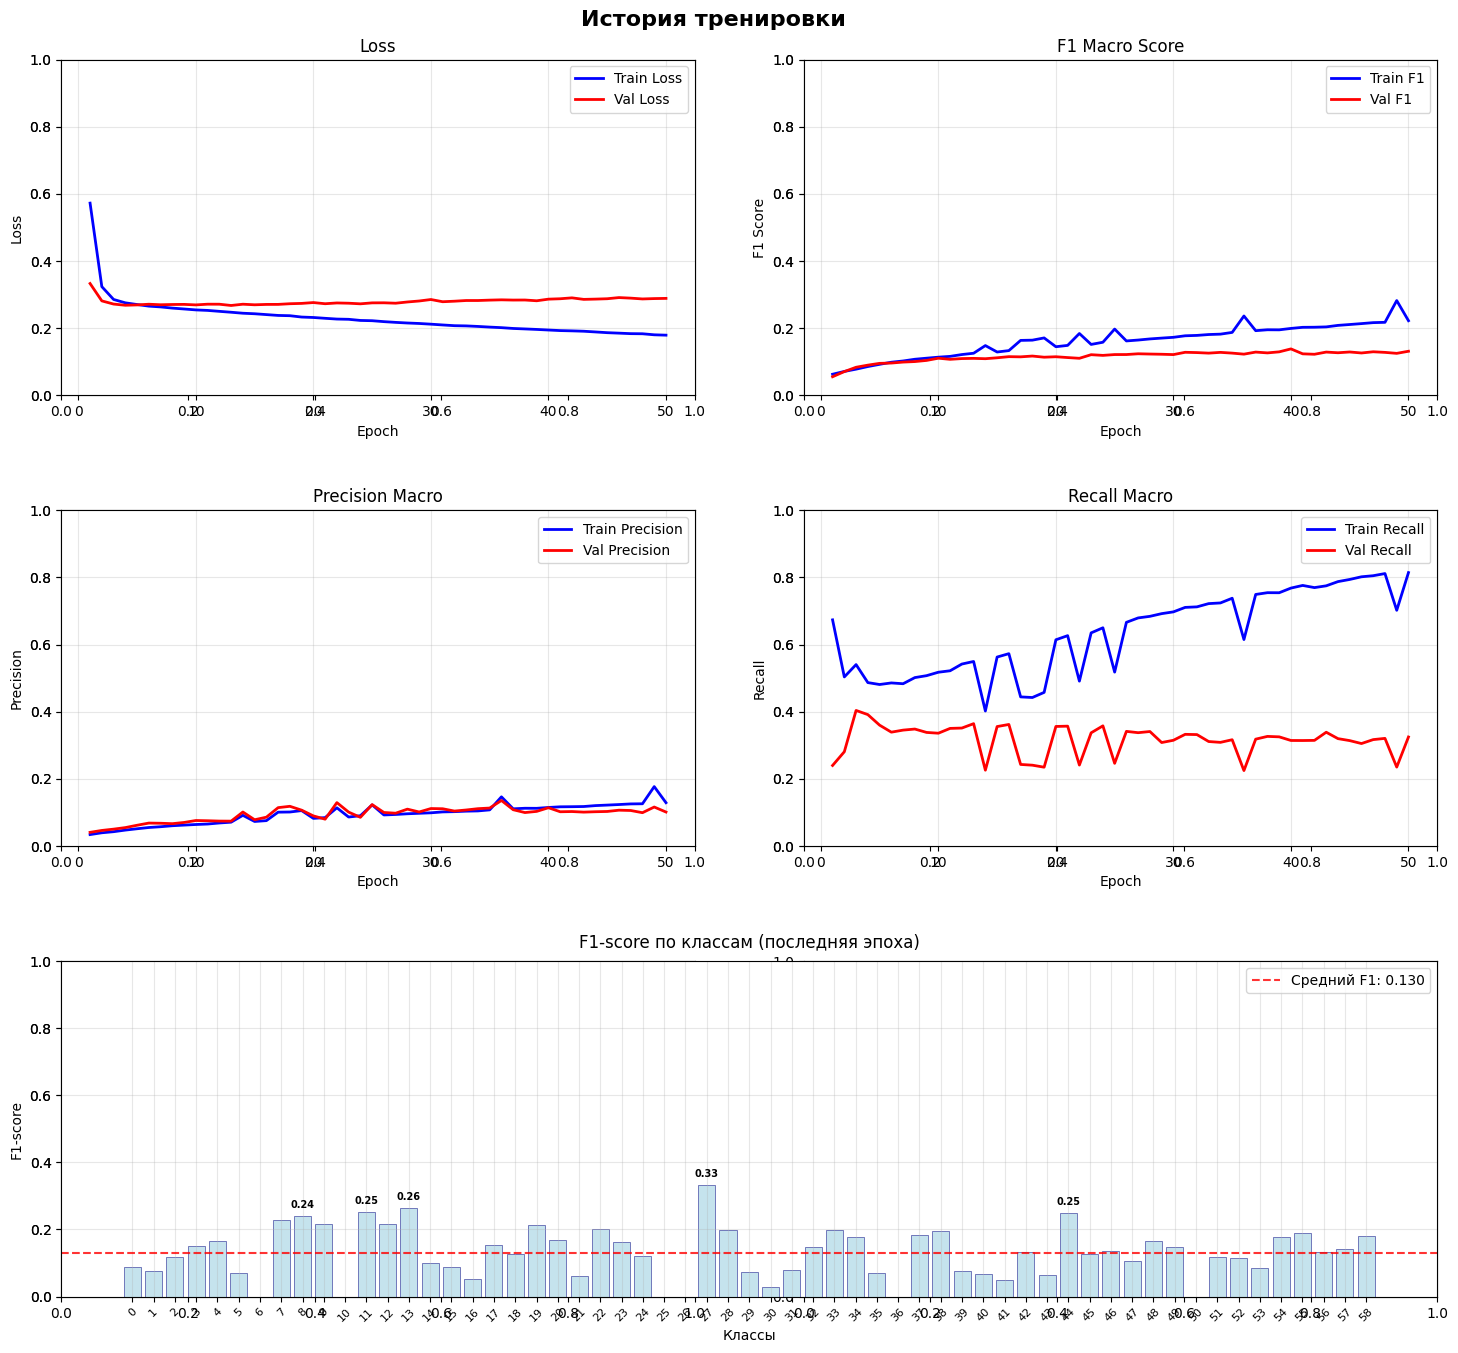

=== MULTI-LABEL DEBUG ===
Outputs range: [-13.866, 2.264]
Probabilities range: [0.000, 0.906]
Sample 0 predictions: [1. 1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Sample 0 targets:     [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Sample 0 matched:     1 correct positive tags
Batch accuracy: 0.887
Positive tag accuracy: 0.748
=== MODEL DEBUG ===
Input data range: [-13.816, 12.225]
Input data mean: 0.677
Model outputs range: [-15.933, 2.581]
Model outputs mean: -4.615
Gradient conv_layers.0.weight: 0.018669
Gradient conv_layers.0.bias: 0.000000
Gradient conv_layers.1.weight: 0.004291
Gradient conv_layers.1.bias: 0.003161
Gradient conv_layers.5.weight: 0.002374
Gradient conv_layers.5.bias: 0.000000
Gradient conv_layers.6.we

In [20]:
#ОБУЧЕНИЕ МОДЕЛИ
def debug_model_predictions(model, loader, threshold=0.5):
    model.eval()
    
    with torch.no_grad():
        for data, targets in loader:
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            probabilities = torch.sigmoid(outputs)
            predictions = (probabilities > threshold).float()  # ⚡ Multi-hot вектор!
            
            print("=== MULTI-LABEL DEBUG ===")
            print(f"Outputs range: [{outputs.min():.3f}, {outputs.max():.3f}]")
            print(f"Probabilities range: [{probabilities.min():.3f}, {probabilities.max():.3f}]")
            
            # Правильная интерпретация
            print(f"Sample 0 predictions: {predictions[0].cpu().numpy()}")
            print(f"Sample 0 targets:     {targets[0].cpu().numpy()}")
            print(f"Sample 0 matched:     {((predictions[0] == targets[0]) & (targets[0] == 1)).sum().item()} correct positive tags")
            
            # Статистика по батчу
            batch_accuracy = ((predictions == targets).float().mean().item())
            positive_accuracy = ((predictions[targets == 1] == 1).float().mean().item())
            
            print(f"Batch accuracy: {batch_accuracy:.3f}")
            print(f"Positive tag accuracy: {positive_accuracy:.3f}")
            break
def debug_model_outputs(model, data_loader):
    model.eval()
    
    with torch.no_grad():
        for data, targets in data_loader:
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            
            print("=== MODEL DEBUG ===")
            print(f"Input data range: [{data.min():.3f}, {data.max():.3f}]")
            print(f"Input data mean: {data.mean():.3f}")
            
            # Проверяем выходы каждого слоя
            print(f"Model outputs range: [{outputs.min():.3f}, {outputs.max():.3f}]")
            print(f"Model outputs mean: {outputs.mean():.3f}")
            
            # Проверяем градиенты
            for name, param in model.named_parameters():
                if param.requires_grad and param.grad is not None:
                    print(f"Gradient {name}: {param.grad.abs().mean():.6f}")
                else:
                    print(f"Gradient {name}: None")
            
            break
def debug_model_weights():
    for name, param in model.named_parameters():
        if 'weight' in name:
            print(f"{name:30} mean: {param.data.mean().item():8.4f} std: {param.data.std().item():8.4f}")
        elif 'bias' in name:
            print(f"{name:30} mean: {param.data.mean().item():8.4f}")

num_epochs = 100          # количество эпох для обучения
threshold = 0.25         # порог для предсказаний
patience = 10           # остановка обучения после N эпох без улучшений

start_epoch = 1         #
history = None          #
best_f1 = 0.0           #

# Инициализация модели
model = AudioCNN(dataset.num_classes)
model.to(device)

print(f"Используется устройство: {device}")
print(f"Количество параметров модели: {sum(p.numel() for p in model.parameters())}\n")

#заменил FocalLoss, на BCEWithLogitsLoss
# criterion = FocalLoss(1, 2.5)
# criterion = nn.MultiLabelSoftMarginLoss(calculate_pos_weight(dataset))
criterion = nn.BCEWithLogitsLoss(pos_weight=calculate_pos_weight(dataset))
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-5)
# optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.9, weight_decay=1e-3)

# Загрузка модели
model, optimizer, history, start_epoch, best_f1, threshold = load_checkpoint(model, optimizer, "../data/models/best_model.pth", device)

# threshold = 0.2

# Запуск обучения
history, best_f1 = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=test_loader,
    optimizer=optimizer,
    criterion=criterion,
    num_epochs=num_epochs,
    threshold = threshold,
    save_dir='../data/models',
    patience=patience,
    start_epoch=start_epoch,
    history=history,
    best_f1=best_f1,
    auto_threshold = True
)

# вывод графиков
plot_training_history(history)

debug_model_predictions(model, train_loader, threshold)
debug_model_outputs(model, train_loader)

In [21]:
import torchaudio 

def random_audio_predictor(model, preprocess_function, class_names, folder_path='../data/train/', device='cuda', threshold=0.5):
    """
    Случайный выбор аудио файла с автовоспроизведением и предсказанием тегов
    """
    
    print("🎲 СЛУЧАЙНЫЙ АУДИО АНАЛИЗ")
    print("=" * 50)
    
    # Находим все аудио файлы в папке
    audio_extensions = ['*.wav', '*.mp3', '*.flac', '*.m4a', '*.ogg']
    audio_files = []
    
    for ext in audio_extensions:
        # Ищем файлы в основной папке и подпапках
        audio_files.extend(glob.glob(os.path.join(folder_path, '**', ext), recursive=True))
        audio_files.extend(glob.glob(os.path.join(folder_path, ext)))
    
    if not audio_files:
        print(f"❌ В папке {folder_path} не найдено аудио файлов!")
        return None
    
    # print(f"📁 Папка: {folder_path}")
    # print(f"📊 Найдено файлов: {len(audio_files)}")
    # print(f"🎚️  Порог: {threshold}")
    
    # Выбираем случайный файл
    selected_file = random.choice(audio_files)
    filename = os.path.basename(selected_file)
    file_path = os.path.dirname(selected_file)
    
    # print(f"\n🎯 Выбран файл: {filename}")
    # print(f"📂 Путь: {file_path}")
    # print("─" * 50)
    

    # Автовоспроизведение аудио
    print("🔊 Автовоспроизведение...")
    display(Audio(selected_file, autoplay=True))
        
    # Предсказание тегов
    print("\n🤖 Анализ тегов...")
    probs, active_tags = quick_predict(
        model=model,
        audio_path=selected_file,
        preprocess_function=preprocess_function,
        class_names=class_names,
        device=device,
        threshold=threshold
    )
    
    if probs is not None:
        # Выводим результаты
        print(f"\n🏷️  ПРЕДСКАЗАННЫЕ ТЕГИ:")
        print("─" * 30)
        
        if active_tags:
            print(f"✅ Найдено тегов: {len(active_tags)}")
            print("\n📋 Список тегов:")
            for tag in active_tags:
                prob = probs[class_names.index(tag)]
                print(f"   • {tag}: {prob:.3f}")
        else:
            print("❌ Нет тегов выше порога")
        
        # # Топ-10 всех предсказаний
        # top_indices = np.argsort(probs)[::-1][:10]
        # print(f"\n🔝 Топ-10 всех предсказаний:")
        # for i, idx in enumerate(top_indices, 1):
        #     prob = probs[idx]
        #     tag = class_names[idx]
        #     marker = "✅" if prob > threshold else "  "
        #     print(f"   {i:2d}. {marker} {tag:<25} {prob:.3f}")
        
        new_dict = {}
        for key, vals in tags_dict.items():
            new_dict[key[3:]] = vals

        print(f"Правильные теги: {new_dict.get(filename, "none")}")

        # Статистика
        print(f"\n📊 СТАТИСТИКА:")
        print(f"   Всего возможных тегов: {len(class_names)}")
        print(f"   Активных тегов: {len(active_tags)}")
        print(f"   Максимальная вероятность: {max(probs):.3f}")
        print(f"   Средняя вероятность: {np.mean(probs):.3f}")
            
        return {
            'file': selected_file,
            'filename': filename,
            'probs': probs,
            'active_tags': active_tags,
            'threshold': threshold
        }           

def preprocess_audio(audio_path, target_sr = 22050, noise = False, start=2048, size=512) -> torch.Tensor:
    waveform, sr = torchaudio.load(audio_path, normalize=True, channels_first=True)
    #уменьшил частоту дискретизации, чтобы ещё меньше датасет весил, а то везде 44100 Гц или почти везде
    if sr != target_sr:
        waveform = torchaudio.functional.resample(waveform, sr, target_sr)
    
    mel_spectrogram = torchaudio.transforms.MelSpectrogram(
        sample_rate=22050,
        n_mels=128,        
        n_fft=2048,       
        hop_length=512,
        f_min=20,
        f_max=11025
    )(waveform)

    mel_spectrogram = torch.log(mel_spectrogram + 1e-6)

    # добавим немного шума (это скорее всего сильно замедлит подготовку данных)
    if noise:
        for x in mel_spectrogram:
            x += random.uniform(-1.0, 1.0)

    return mel_spectrogram[0,:start,:start+size]

def quick_predict(model, audio_path, preprocess_function, class_names, device='cuda', threshold=0.5):
    """
    Функция предсказания тегов для аудио файла
    """
    model.to(device)
    model.eval()
    
    try:
        # Препроцессинг
        mel_spec = preprocess_function(audio_path)
        
        # Добавляем batch dimension и перемещаем на устройство
        if len(mel_spec.shape) == 3:  # [channels, height, width]
            input_tensor = mel_spec.unsqueeze(0)  # [1, channels, height, width]
        else:
            input_tensor = mel_spec.unsqueeze(0).unsqueeze(0)  # [1, 1, height, width]
        
        input_tensor = input_tensor.to(device)
        
        # Предсказание
        with torch.no_grad():
            outputs = model(input_tensor)
            probs = torch.sigmoid(outputs).cpu().numpy()[0]
        
        # Собираем активные теги
        active_tags = []
        for i, (class_name, prob) in enumerate(zip(class_names, probs)):
            if prob > threshold:
                active_tags.append(class_name)
        
        return probs, active_tags
        
    except Exception as e:
        print(f"❌ Ошибка во время предсказания: {e}")
        return None, None

best_model = AudioCNN(dataset.num_classes)
best_model,_,_,_,_,threshold = load_checkpoint(best_model, optimizer, "../data/models/best_model.pth", device)
best_model.to(device)
best_model.eval()

# Простой вызов - один случайный файл
random_audio_predictor(
    model=best_model,
    preprocess_function=preprocess_audio,
    class_names=dataset.get_class_names(),
    folder_path='../data/train', #'/home/egr/Музыка',  # Ваша папка с аудио
    device=device,
    threshold=threshold  # Можно настроить порог
)


Загружен чекпоинт эпохи 40
Лучший F1: 0.1373
Всего эпох в истории: 40 

🎲 СЛУЧАЙНЫЙ АУДИО АНАЛИЗ
🔊 Автовоспроизведение...



🤖 Анализ тегов...

🏷️  ПРЕДСКАЗАННЫЕ ТЕГИ:
──────────────────────────────
✅ Найдено тегов: 14

📋 Список тегов:
   • ambiental: 0.134
   • dark: 0.134
   • documentary: 0.110
   • dramatic: 0.120
   • dream: 0.164
   • emotional: 0.354
   • epic: 0.363
   • film: 0.332
   • inspiring: 0.159
   • melodic: 0.157
   • movie: 0.116
   • romantic: 0.153
   • sad: 0.417
   • soundscape: 0.106
Правильные теги: {'dark'}

📊 СТАТИСТИКА:
   Всего возможных тегов: 59
   Активных тегов: 14
   Максимальная вероятность: 0.417
   Средняя вероятность: 0.067


/home/egr/projects/nmus/.venv/lib/python3.12/site-packages/torchaudio/_backend/utils.py:213: UserWarning: In 2.9, this function's implementation will be changed to use torchaudio.load_with_torchcodec` under the hood. Some parameters like ``normalize``, ``format``, ``buffer_size``, and ``backend`` will be ignored. We recommend that you port your code to rely directly on TorchCodec's decoder instead: https://docs.pytorch.org/torchcodec/stable/generated/torchcodec.decoders.AudioDecoder.html#torchcodec.decoders.AudioDecoder.
  warnings.warn(
/home/egr/projects/nmus/.venv/lib/python3.12/site-packages/torchaudio/_backend/ffmpeg.py:88: UserWarning: torio.io._streaming_media_decoder.StreamingMediaDecoder has been deprecated. This deprecation is part of a large refactoring effort to transition TorchAudio into a maintenance phase. The decoding and encoding capabilities of PyTorch for both audio and video are being consolidated into TorchCodec. Please see https://github.com/pytorch/audio/issues/3

{'file': '../data/train/66/594266.mp3',
 'filename': '594266.mp3',
 'probs': array([8.18856508e-02, 3.09655499e-02, 8.39325041e-03, 1.33630648e-01,
        3.03121693e-02, 7.97978491e-02, 9.58030820e-02, 2.94046564e-04,
        2.57444382e-02, 1.05914203e-02, 4.01525386e-02, 1.04624685e-02,
        1.34402931e-01, 7.25884549e-03, 1.09899931e-01, 5.34758829e-02,
        1.19819179e-01, 1.64254427e-01, 3.53919178e-01, 5.59990220e-02,
        3.62653315e-01, 9.33843572e-03, 3.32411379e-01, 3.18002165e-03,
        5.73199126e-04, 5.81492903e-03, 1.85680098e-03, 7.80588947e-03,
        7.35088997e-03, 8.18595104e-03, 3.76442783e-02, 4.64881537e-03,
        1.59115314e-01, 7.56643638e-02, 1.15686739e-02, 5.13495095e-02,
        3.65999341e-02, 1.57284677e-01, 2.12498549e-02, 1.15700141e-01,
        3.19328979e-02, 6.90316490e-04, 1.56048089e-02, 6.35449588e-02,
        5.74218929e-02, 3.12445057e-03, 1.52535781e-01, 4.17401493e-01,
        4.05257306e-04, 1.15675284e-02, 2.51024570e-02, 1.06